In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
from time import time

import numpy as np
import rustworkx as rx

import matplotlib.pyplot as plt

from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit.algorithms import NumPyEigensolver as ClassicalEigensolver
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, ADAM, GradientDescent, NFT

from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

from heisenberg_model import HeisenbergModel

In [57]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

class VQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        def objective(x):
            job = self._estimator.run([self._circuit], [operators], [x])
            estimator_result = job.result()
            value = estimator_result.values[0]
            if self._callback is not None:
                self._callback(value)
            return value
            
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        res = self._optimizer.minimize(objective, x0=x0)
        

        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

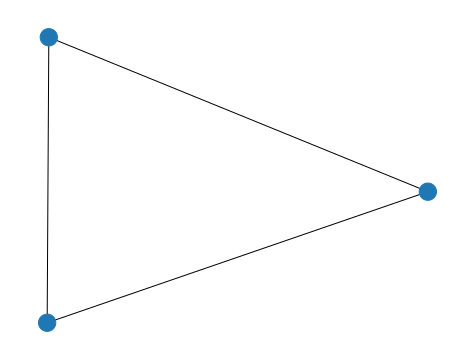

In [25]:
num_sites = 3
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 0, t),
]

graph.add_edges_from(edge_list)
line_unit_cell = Lattice(graph)

line_unit_cell.draw()
plt.show()

In [26]:
heisenberg_model = HeisenbergModel.uniform_parameters(
    lattice=line_unit_cell,
    uniform_interaction=1.0,
    uniform_onsite_potential=0.0,
)

logarithmic_mapper = LogarithmicMapper()
hamiltonian = 4 * logarithmic_mapper.map(heisenberg_model.second_q_ops().simplify())
hamiltonian

PauliSumOp(SparsePauliOp(['ZZI', 'ZIZ', 'IZZ', 'YYI', 'YIY', 'IYY', 'XXI', 'XIX', 'IXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [27]:
exact_solver = ClassicalEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues)

gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-3. -3. -3.]


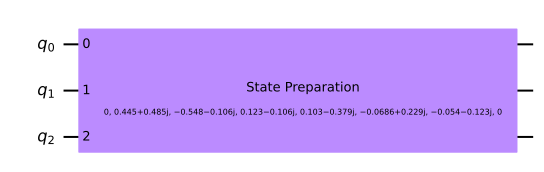

In [28]:
from qiskit import QuantumCircuit

gs_circuit = exact_result.eigenstates[0].to_circuit_op().to_circuit()
gs_circuit.draw("mpl")

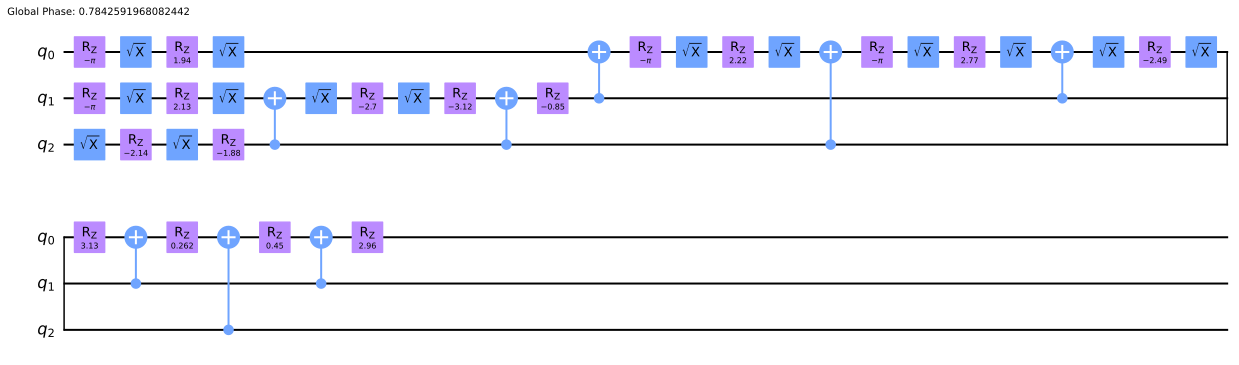

In [31]:
from qiskit import transpile

transpiled_gs_circuit = transpile(gs_circuit, basis_gates=['cx', 'rz', 'sx', 'x'], optimization_level=3)
transpiled_gs_circuit.draw("mpl")

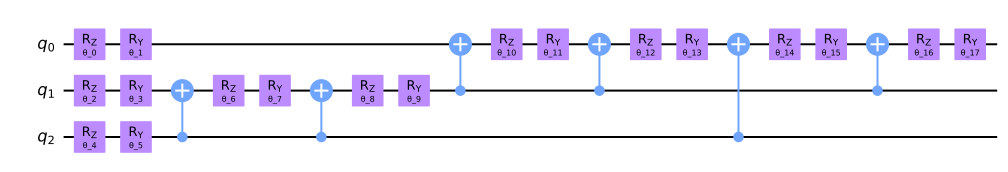

In [50]:
from qiskit.circuit import Parameter

ansatz = QuantumCircuit(3)

j = 0

for i in range(3):
    ansatz.rz(Parameter('θ_' + str(j)), i)
    j += 1
    ansatz.ry(Parameter('θ_' + str(j)), i)
    j += 1

ansatz.cx(2, 1)

ansatz.rz(Parameter('θ_' + str(j)), 1)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 1)
j += 1

ansatz.cx(2, 1)

ansatz.rz(Parameter('θ_' + str(j)), 1)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 1)
j += 1

ansatz.cx(1, 0)

ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(1, 0)

ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(2, 0)

ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(1, 0)

ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.draw("mpl")

In [72]:
optimizer = ADAM(maxiter=2000)
# optimizer = NFT(maxiter=1000)

In [73]:
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

estimator = Estimator([ansatz], [hamiltonian])

vqe = VQE(estimator, ansatz, optimizer, callback=callback)

start = time()
result = vqe.compute_minimum_eigenvalue(hamiltonian)
end = time()

print(result)
print(f'Execution Time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 2000,
    'eigenstate': None,
    'eigenvalue': -2.9999999879300625,
    'optimal_circuit': None,
    'optimal_parameters': array([ 0.50262376,  0.76833599,  0.46473795,  0.08770341,  0.7198769 ,
        1.43293771, -0.47054211,  0.83871771, -0.56313227,  0.58103855,
        0.17091253, -0.49557796,  0.36984862,  0.76319777,  0.59983991,
       -0.67429874, -0.83579393, -0.37024636]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
Execution Time (s): 41.20


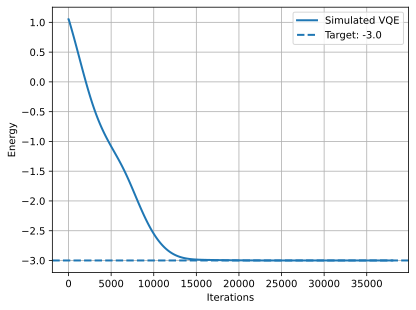

In [74]:
plt.plot(intermediate_info, lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')

plt.axhline(y=gs_energy, ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
# plt.show()

plt.savefig('optimization.svg', format="svg")

In [75]:
def relative_error(target, measured):
    return abs((target - measured) / target)

error = relative_error(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}.')
print(f'Computed ground state energy: {result.eigenvalue:.10f}.')
print(f'Relative error: {error:.8f}.')

Expected ground state energy: -3.0000000000.
Computed ground state energy: -2.9999999879.
Relative error: 0.00000000.
